# Scale Invariant Feature Detector
by Robinson Garcia

sources:


Ref: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
Ref: https://www.dropbox.com/sh/26xgy96py8itk14/AABhgCbYzraeSMkDpjY92kFVa/Lecture%20slides?dl=0&preview=2017f.Week10.Topic15.lecture.sift.pdf&subfolder_nav_tracking=1
Ref: https://cs.nyu.edu/~fergus/teaching/vision_2012/3_Corners_Blobs_Descriptors.pdf
Ref: https://arxiv.org/pdf/1603.09114.pdf

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

import src.c.patches3 as cpy_patches3
import src.c.nn as cpy_nn
import src.c.GaussianFilter as cpy_GF
import src.c.feature_aux as cpy_features
import src.c.im2col as cpy_im2col

#from src.src import *
from numba import jit
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Feature extractor:

## Image processing / filtering / gradients

def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append(math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))

    return np.array(G).reshape(w,h)/np.sum(np.array(G))

In [2]:
def Expand_stack(im_stack,size):
    N,H,W = im_stack.shape
    _,h,w = size
    factor = int(H/h)
    base=np.zeros((N,h,w))
    i = np.arange(H)*factor
    j = np.arange(W)*factor
    j = np.repeat(j[np.newaxis,:],H,axis=0)
    i = np.repeat(i[:,np.newaxis],W,axis=1)
    print(i.shape,j.shape)
    print(base.shape)
    base[:,i,j] = im_stack
    return base


def get_im2col_indices_blur(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)


def conv_octave(im,g,stride=1,C=3):
    im = im[:,np.newaxis,:,:]
    N,_,H,W = im.shape
    _,h,w = g.shape
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    
    cols = cpy_im2col.im2col_cython(im, h, w, h_pad,stride)
      
    k,i,j = get_im2col_indices_blur((N,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

    #im_padded = np.pad(im,((0,0),(0,0),(h_pad,h_pad),(w_pad,w_pad)),'mean')
    #cols = im_padded[:,k,i,j]
    

    g = g.reshape((N,-1))

    
    sol = np.squeeze(np.matmul(g[:,np.newaxis,:],cols))
    
    return sol.reshape(N,H,W)


In [3]:
def conv_octave_cython(im,g,stride=1,C=3):
    im = im[:,np.newaxis,:,:]

    N,_,H,W = im.shape
    _,h,w = g.shape

    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    ii = np.zeros((N,H*W))
    for t,i in enumerate(im):
        img = i[np.newaxis,:,:]
        cols = cpy_im2col.im2col_cython(img, h, w, h_pad,stride)
        gg = g[t].flatten()
        ii[t]=np.matmul(cols.T,gg)
    return ii.reshape(-1,H,W)

In [4]:
def filter_stack(sig0,s,h,w):
    k = 2**(1/s)
    sigma = np.power(k,np.arange(s+1))*sig0
    g = []
    for std in sigma:
        g.append(cpy_GF.GaussianFilter(h,w,std))
    return np.stack(g),sigma
            

## Pyramid of DOG images:
$$D(x,y,\rho) = I(x,y)*(G(x,y,k\rho) - G(x,y,\rho))$$
for $$\rho=\sigma.k\sigma,k^2\sigma,...,k^{s-1}\sigma$$

In [5]:
def scale_zero2one(M):
    
    min_ = M.min()
    max_ = M.max()
    M = (M-min_)/(max_-min_)

    return M

In [6]:
def octave(im_stack,factor,sig0=1.6,s=5,h=3,w=3):
    g,sigma = filter_stack(sig0,s,h,w)
    s1 = np.array([[0,1,0],[0,0,0],[0,-1,0]])
    s2 = np.repeat(s1.T[np.newaxis,:,:],s+1,axis=0)
    s1 = np.repeat(s1[np.newaxis,:,:],s+1,axis=0)
    
    L = conv_octave_cython(Reduce_stack(im_stack,factor),g)
    L = scale_zero2one(L)
    #print('Reduced shape: {}'.format(L.shape))
    
    D = L[1:s+1] - L[0:s]
    
    L_gradx = conv_octave_cython(L,s2)
    L_grady = conv_octave_cython(L,s1)
    #plt.imshow(L_gradx[0,:,:],**{'cmap':'gray'})
    #plt.show()
    #plt.imshow(L_grady[0,:,:],**{'cmap':'gray'})
    #plt.show()
    #plt.imshow(D[0,:,:],**{'cmap':'gray'})
    #plt.show()

    return D,L,sigma,(L_gradx,L_grady)

In [7]:
%%capture
'''
Using cythonized function instead
def get_patches3(D,xk,h=3,w=3):

    N,H,W = D.shape

    stride=1

    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)
    
    
    h_ = int((h-1)/2)
    w_ = int((w-1)/2)
    #shape_=(3,3)
    patches=[]
    D_padded = np.pad(D,((0,0),(h_pad,h_pad),(w_pad,w_pad)),'constant')

    for f in range(xk.shape[0]):
        i,j,k,_= xk[f].astype(int)
        
        i+=h_pad
        j+=w_pad
        patches.append(D_padded[k,i-h_:i+h_+1,j-w_:j+w_+1])
        shape = D_padded[k,i-h_:i+h_+1,j-w_:j+w_+1].shape
        if np.sum(shape)==0:
            print(shape,i,j,k)
            print('check get patches function')

    return np.stack(patches)
'''     

## Detecting DOG extrema

Find all pixels that correspond to extrema of $D(x,y,\rho)$. For each $(x,y,\rho)$, check wether $D(x,y,\rho)$ is greater than (or smaller than) all of its neighbours in current scale and adjacent scales above & below.

In [8]:
def get_im2col_indices_conv2d_max(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def conv2d_max(f,g,k=1,**kwargs):
    #f = f[:,np.newaxis,:,:]
    #f = np.repeat(f,3,axis=1)

    N,H,W=f.shape

    n = np.tile(np.arange(3),N-2) + np.repeat(np.arange(N-2),3)
    f = f[n,:,:].reshape((N-2,3,H,W))

    N,C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_conv2d_max((N,C,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[:,k,i,j]

    xc = int((h*w-1)/2)
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),1)

    cond = ((f[:,1,:,:].flatten() >
             np.max(cols,axis=1).flatten())|(f[:,1,:,:].flatten() <
                                   np.min(cols,axis=1).flatten()))

    return np.moveaxis(cond.reshape(N,H,W),0,2)

## Refining location of Extrema
2nd order taylor expansion of D at $(x,y,\rho)$:
$$D\left(\Delta\vec{x}^{\,}\right) = D(\vec{x}^{\,}) +\left(\frac{\partial D}{\partial \vec{x}^{\,}}\right)^T\Delta\vec{x}^{\,} + \frac{1}{2}\left(\Delta\vec{x}^{\,}\right)^T\frac{\partial^2 D}{\partial \vec{x}^{\,2}}\left(\Delta\vec{x}^{\,}\right)$$
Gradient wrt $\Delta\vec{x}^{\,}$:
$$\frac{\partial D}{\partial \Delta\vec{x}^{\,} } = \left(\frac{\partial D}{\partial \vec{x}^{\,}}\right) + \frac{\partial^2 D}{\partial \vec{x}^{\,2}}\left(\Delta\vec{x}^{\,}\right)$$
Minimum occurs when $\frac{\partial D}{\partial \Delta\vec{x}^{\,} }=0$
$$\Delta\vec{x}^{\,}  = - \left(\frac{\partial^2 D}{\partial \vec{x}^{\,2}}^{-1}\right)\left(\frac{\partial D}{\partial \vec{x}^{\,}}\right)$$

All gradients estimated using finite differences


## Compute new locations and prune insignificant extrema:

Find the Hessian for each key point and prune if $\frac{Tr^2(H)}{Det(H)}>(1.1)^2$.

Look for Harris Corner detector to understand this

## Keypoint orientation assignment
 Contribution to the bin is: $$\left|\nabla I(x,y)\right|G_{1.5\rho_i}(d)$$

In [9]:
def build_sig(xk,sigma):
    sig = np.zeros(xk.shape[0])
    k=0
    for i in xk:
        sig[k] = sigma[i[2]]
        k+=1
    return np.vstack((xk.T,sig)).T
    

In [10]:
def HOG(L_grad,xk,h=9,w=9):
    Lx,Ly = L_grad
    Lmod = np.sqrt(Lx**2+Ly**2)
    rho = np.arctan2(Ly,Lx)
    rho[rho<0]+=2*math.pi
    Lmod_patches = cpy_patches3.get_patches3(Lmod,xk,h,w)
    rho_patches = cpy_patches3.get_patches3(rho,xk,h,w)
    return Lmod_patches,rho_patches

In [11]:
def harris2(D,xk,edge_th):
    
    #gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    gy = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    gx = gy.T
    gx = np.repeat(gx[np.newaxis,:,:],D.shape[0],axis=0)
    gy = np.repeat(gy[np.newaxis,:,:],D.shape[0],axis=0)

    D2grad_x = conv_octave_cython(D,gx)
    D2grad_y = conv_octave_cython(D,gy)

    Dxx = np.sum(cpy_patches3.get_patches3(D2grad_x,xk),axis=(1,2))
    Dyy = np.sum(cpy_patches3.get_patches3(D2grad_y,xk),axis=(1,2))

    H = np.array([[Dxx**2,Dxx*Dyy],[Dxx*Dyy,Dyy**2]])

    tr = np.trace(H)**2
    det = np.linalg.det(np.moveaxis(H,2,0))

    #R = det - 0.04*tr
    return np.divide(tr,det,out=np.zeros_like(tr),where=det!=0)<((edge_th+1)**2)/10

In [12]:
def get_deriv(pyr,kp):
    pyr = np.moveaxis(pyr,0,2)

    z = kp[:,2].astype(int)
    y = kp[:,1].astype(int)+1
    x = kp[:,0].astype(int)+1


    pyr = np.pad(pyr,((1,1),(1,1),(0,0)),'maximum')

    Ix = pyr[x+1,y,z] - pyr[x-1,y,z]
    Iy = pyr[x,y+1,z] - pyr[x,y-1,z]
    Is = pyr[x,y,z+1] - pyr[x,y,z-1]
    Ixy = pyr[x+1,y+1,z] - pyr[x-1,y-1,z]

    #H = np.array([[Ix,Ixy],[Ixy,Iy]])

    Ixx = pyr[x+1,y,z] - 2*pyr[x,y,z] + pyr[x-1,y,z]
    Iyy = pyr[x,y+1,z] - 2*pyr[x,y,z] + pyr[x,y-1,z]
    Iss = pyr[x,y,z+1] - 2*pyr[x,y,z] + pyr[x,y,z-1]
    Ixxyy = pyr[x+1,y+1,z] - 2*pyr[x,y,z] + pyr[x-1,y-1,z]
    Ixxss = pyr[x+1,y,z+1] - 2*pyr[x,y,z] + pyr[x-1,y,z-1]
    Iyyss = pyr[x,y+1,z+1] - 2*pyr[x,y,z] + pyr[x,y-1,z-1]

    H = np.array([[Ixx,Ixxyy,Ixxss],[Ixxyy,Iyy,Iyyss],[Ixxss,Iyyss,Iss]])
    J = np.array([[Ix**2,Ix*Iy],[Ix*Iy,Iy**2]])
    dx = np.array([Ix,Iy,Is])
    return H,dx,J

In [13]:

def refine_location_prune(im,D,kp,peak_th=0.03,edge_th=10,debug=False):
    D = D**2
    #D = (D-D.min())/(D.max()-D.min())
    
    H,dx,J = get_deriv(D,kp)

    U,S,V = np.linalg.svd(np.moveaxis(H,2,0))
    S = S[:,:,np.newaxis]*np.diag(np.ones(3))
    A = np.linalg.inv(S)
    H_inv = np.matmul(-np.matmul(A,S),V)
    deltas = np.squeeze(np.matmul(H_inv,np.moveaxis(dx,1,0)[:,:,np.newaxis]))
    #deltas=np.round(deltas)

    xk=kp
    D[xk[:,2].astype(int),xk[:,0].astype(int),xk[:,1].astype(int)]+=0.5*np.sum(dx.T*deltas,axis=1)

    Ds = D[xk[:,2].astype(int),xk[:,0].astype(int),xk[:,1].astype(int)]
    Ds = (Ds-Ds.min())/(Ds.max()-Ds.min())
    if debug==True: print('Maximum contrast: {}'.format(Ds.max()))
    if debug==True: print('Minimum contrast: {}'.format(Ds.min()))
    if debug==True: print('Average contrast: {}'.format(Ds.mean()))
    cond1 = Ds > peak_th
    if debug==True: print("Number of kps removed after th: {}".format(np.sum(~cond1)))
    #if kp.shape[1]!=0:
    cond2 = harris2(D,kp,edge_th)
    if debug==True: print("Number of kps removed edge extraction: {}".format(np.sum(~cond2)))

    keep = ((cond2) & (cond1))
    return (deltas,keep)

# Descriptor

In [14]:
%%prun
def features(L_grad,xk,ilum_sat=0.2):
    N = xk.shape[0]
    Lx,Ly = L_grad
    Lmod = np.sqrt(Lx**2+Ly**2)
    rho = np.arctan2(Ly,Lx)
    
    
    rho[rho<0]+=2*math.pi

    Lmod_patches = get_patches2(Lmod,xk[:,:4],16,16)
    rho_patches = get_patches2(rho,xk[:,:4],16,16)
   
    
    rho_patches = xk[:,4][np.newaxis,np.newaxis,:]- rho_patches 
    rho_patches[rho_patches<0]+=2*math.pi
    

    Imag = split_tensor(Lmod_patches)#np.moveaxis(Lmod_patches,0,2))
    Irho = split_tensor(rho_patches)
    
    bins = np.arange(0,2*math.pi,2*math.pi/8)
    hist_patches = np.reshape(np.digitize(Irho,bins)-1,(16,16,-1))
    Imag = Imag.reshape((16,16,-1))
        
    return cpy_features.build_fk(N,xk,hist_patches,Imag,ilum_sat)



%%prun
def features(L_grad,xk,ilum_sat=0.2):
    N = xk.shape[0]
    Lx,Ly = L_grad
    Lmod = np.sqrt(Lx**2+Ly**2)
    rho = np.arctan2(Ly,Lx)
    
    
    rho[rho<0]+=2*math.pi

    Lmod_patches = get_patches2(Lmod,xk[:,:4],16,16)
    rho_patches = get_patches2(rho,xk[:,:4],16,16)
   
    
    rho_patches = xk[:,4][np.newaxis,np.newaxis,:]- rho_patches 
    rho_patches[rho_patches<0]+=2*math.pi
    

    Imag = split_tensor(Lmod_patches)#np.moveaxis(Lmod_patches,0,2))
    Irho = split_tensor(rho_patches)
    
    bins = np.arange(0,2*math.pi,2*math.pi/8)
    hist_patches = np.reshape(np.digitize(Irho,bins)-1,(16,16,-1))
    Imag = Imag.reshape((16,16,-1))
    
    fk = np.zeros((N,8*16))
    for kp in range(N):
        fk1=np.empty(0)
        sig = split_matrix(cpy_GF.GaussianFilter(16,16,1.5*xk[kp,3]))
        
        for i in range(16):
            sig_ = sig[:,:,i]
            contrib = np.zeros(8)
            for j in range(16):
                contrib[hist_patches[j,i,kp]]+=Imag[j,i,kp]*sig_.flatten()[j]

            fk1 = np.append(fk1,contrib)
        vec = np.hstack(fk1)
        norm = vec/np.linalg.norm(vec)
        vec = np.clip(norm,None,ilum_sat)
        fk[kp,:] = vec/np.linalg.norm(vec)
            

            #orient.append(bins[np.argmax(norm)])      
            
        
    return fk

In [15]:

def SIFT(im,sig=1.6,N=2,s=5,max_sup_window = (3,3),peak_th=0.03,edge_th=10,ilum_sat=0.2,debug=False):
    #im=im/255
    im_stack = np.repeat(im[np.newaxis,:,:],s+1,axis=0)
    factor=0
    pyr=[]
    xks=[]
    fks=[]
    if debug==True: print('Original image size: {}'.format(im_stack.shape))
    for i in range(N):    
        if debug==True: print('factor: {}'.format(i))

        D,L,sigma,L_grad = octave(im_stack,factor=i,sig0=sig,s=s,h=3,w=3)
    
        xk = np.moveaxis(D[1:-1],0,2)*conv2d_max(D,max_sup_window)

        xk = np.argwhere(xk)
        if debug==True: print('Initial number of kps: {}'.format(xk.shape[0]))
        if debug==True: print('Scale range: {}'.format(np.round(sigma,2)))

        xk = build_sig(xk,sigma)

        deltas,keep = refine_location_prune(im,D,xk,peak_th,edge_th,debug)
        if debug==True: print('Remaining kps after prunning: {}'.format(np.sum(keep)))
        #xk[:,:3] += deltas
        xk = xk[keep,:]
        
        xk = set_rho(L_grad,xk,h=9,w=9)

        fk = features(L_grad,xk,ilum_sat)
        #fk = cpy_patch.features(L_grad,xk,ilum_sat)

        
        xk[:,:2] = xk[:,:2]*(2**i)
        sig*=2
        
        if debug==True:
            plt.imshow(np.squeeze(im),**{"cmap":"gray"})
            plt.scatter(xk[:,1],xk[:,0],s=1,color='red')
            plt.show()

        xks.append(xk)
        fks.append(fk)

    xk = np.vstack(xks)
    fk = np.vstack(fks) 
    return xk,fk
    
    
    


# Helper functions

In [16]:
def split_tensor(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)

    k = A.shape[2]

    z = (np.repeat(np.zeros((64,4)),k).reshape((64,4,-1)) + np.arange(k)).astype(int)
    x = np.repeat(x[:,:,np.newaxis],k,axis=2)
    y= np.repeat(y[:,:,np.newaxis],k,axis=2)


    return np.dstack(np.split(A[x,y,z],16)).reshape((4,4,16,-1))


def split_matrix(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)
    return np.dstack(np.split(A[x,y],16))


In [17]:
def Reduce_stack(stack,k):

    N,H0,W0 = stack.shape

    H=H0-H0%(2**k)
    stack = stack[:,:H,:]
    
    W=W0-W0%(2**k)
    stack = stack[:,:,:W]
    
    i = np.repeat(np.arange(0,H,2**k)[np.newaxis,:],W//(2**k),axis=0)
    j = np.repeat(np.arange(0,W,2**k)[:,np.newaxis],H//(2**k),axis=1)


    return np.moveaxis(stack[:,i,j],2,1)

def Reduce(im,k):   
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

In [18]:
def get_patches2(octave,kp,h=9,w=9):

    kp = kp.T

    h_ = int((h-1)/2)+1
    w_ = int((w-1)/2)+1
    octave = np.pad(octave,((0,0),(h_,h_),(w_,w_)),'mean')
    mypks=kp[:3].astype(int).T

    patches=[]
    count=0
    for i in mypks:

        p = octave[i[2],i[0]:i[0]+h,i[1]:i[1]+w]

        patches.append(p)
        count+=1
        if p.shape[0]==0:
            print('patch w/ zero shape on kp {}'.format(i))
    return np.dstack(patches)

In [19]:
def set_rho(L_grad,xk,h=9,w=9):
    N = xk.shape[0]
    bins = np.arange(0,2*math.pi,2*math.pi/36)
    Lmod_patches,rho_patches = HOG(L_grad,xk,h,w)
    hist_patches = np.reshape(np.digitize(rho_patches,bins)-1,(N,-1))
    Lmod_patches = Lmod_patches.reshape(N,-1)
    rho_patches = rho_patches.reshape(N,-1)


    orient = []
    for e in range(N):
        sig = cpy_GF.GaussianFilter(h,w,1.5*xk[e,3]).flatten()
        contrib = np.zeros(h*w)
        for i in range(h*w):
            contrib[hist_patches[e,i]]+=Lmod_patches[e,i]

        if np.linalg.norm(contrib)==0:
            orient.append(0)
            continue
        norm = (contrib/np.linalg.norm(contrib))*sig
        if np.sum(norm>0.8)>1:
            print('include the kp split on HOG')
            orient.append(bins[np.argmax(norm)])
        orient.append(bins[np.argmax(norm)])
    
    return np.vstack((xk.T,orient)).T
    

# Affine transformation LS

In [20]:
def Affine(pairs,num=4):

    idx = np.arange(pairs[0].shape[0])

    i = np.random.choice(idx,num)
    
    A = np.zeros((2*num,6))

    A[:num,0] = pairs[0][i,0]
    A[:num,1] = pairs[0][i,1]
    A[:num,4] = np.ones(num)

    A[num:,2] = pairs[0][i,0]
    A[num:,3] = pairs[0][i,1]
    A[num:,5] = np.ones(num)


    y = np.zeros(2*num)
    y[:num] = pairs[1][i,0]
    y[num:] = pairs[1][i,1]
    

    w = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(y))

    return w,affine_error(pairs,w),pairs[0][i],pairs[1][i]

In [21]:
def affine_error(pairs,w):

    A = np.reshape(w,(2,3))

    x0 = np.vstack((pairs[0][:,:2].T,np.ones(pairs[0].shape[0])))

    x1_ = A.dot(x0)
    

    return np.sum((x1_ - pairs[1][:,:2].T)**2,axis=0)

In [22]:
def affine_project(pairs,best_fit,w):

    x0 = np.vstack((pairs[0][best_fit,:2].T,np.ones(np.sum(best_fit))))

    a,b,e,c,d,f = w
    
    A = np.array([[a,b,e],[c,d,f]])
    
    return A.dot(x0)
    

# Homography LS

In [23]:
from scipy import linalg

In [24]:
def build_A(num, pairs,i):
    
    A = np.zeros((2*num,9))

    A[:num,0] = pairs[0][i,0]
    A[:num,1] = pairs[0][i,1]
    A[:num,2] = np.ones(num)

    A[:num,6] = -1*pairs[1][i,0]*pairs[0][i,0]
    A[:num,7] = -1*pairs[1][i,0]*pairs[0][i,1]
    A[:num,8] = -1*pairs[1][i,0]


    A[num:,3] = pairs[0][i,0]
    A[num:,4] = pairs[0][i,1]
    A[num:,5] = np.ones(num)

    A[num:,6] = -1*pairs[1][i,1]*pairs[0][i,0]
    A[num:,7] = -1*pairs[1][i,1]*pairs[0][i,1]
    A[num:,8] = -1*pairs[1][i,1]
    return A

def Homography(pairs,num=4):
    idx = np.arange(pairs[0].shape[0])

    i = np.random.choice(idx,num)

    A = build_A(num,pairs,i)

    U,S,V = linalg.svd(A)
    
    h = V[-1]
    
    

    e = homography_error(pairs,h) 

    return h,e,pairs[0][i],pairs[1][i]


In [25]:

def homography_error(pairs,h):

    H = np.reshape(h,(3,3))

    x0 = np.vstack((pairs[0][:,:2].T,np.ones(pairs[0].shape[0])))

    x1_ = H.dot(x0)
    
    x1_ = np.divide(x1_[:2,:],x1_[2,:],out=np.zeros_like(x1_[:2,:]),
                    where=x1_[2,:]!=0)
    
    return np.sum((x1_ - pairs[1][:,:2].T)**2,axis=0)

# Matching: Nearest Neighboor

In [26]:
%%capture
'''Using cythonized function instead
def npndarray_nearest_neighboor(fk1,xk1,fk2,xk2,crt=0.8):
    
    fk=fk1
    count=0
    idx2 = np.empty(0,dtype=np.int)
    idx1= np.empty(0,dtype=np.int)
    phi_ = np.empty(0,dtype=np.int)
    
    for i in range(fk.shape[0]):
        v = fk[i]
        d = np.sum((fk2-v)**2,axis=1)

        f1,f2 = np.argsort(d)[:2]
        if np.sum((v - fk2[f2])**2)==0:
            continue

        phi = np.sum((v - fk2[f1])**2)/np.sum((v - fk2[f2])**2)
        
        if phi<crt:
            idx2 = np.append(idx2,f1)
            idx1 = np.append(idx1,i)
            phi_= np.append(phi_,[phi])

    pairs = (xk1[idx1,:],xk2[idx2])

    idx = np.argsort(phi_)
    return pairs,idx
'''

# Random Sample Consensus - RANSAC

Likelihood that S trials will fail:
$$1-P=(1-p^k)^s$$

For a given probability of having inliers, the required minimum number of trials S is:
$$S = \frac{log(1-P)}{log(1-p^k)}$$

In [27]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC(im1,im2,pairs,min_pts=4,p=0.1,P=.99,th=5,type_='affine'):
    
    S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
    num_pts = pairs[0].shape[0]
    
    best_fit=0
    
    for i in range(S):
        try:
            if type_=='affine':
                w,e,x1,x2 = Affine(pairs,min_pts)
            else:
                w,e,x1,x2 = Homography(pairs,min_pts)
            
            inliers = np.sum(e<th**2)
            
            if inliers>=best_fit:
                best_w = w
                best_e = np.sum(e)
                best_x1 = x1
                best_x2 = x2
                idx = e<th**2
                best_fit = inliers
                p = inliers/num_pts
                S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
 
        except:     
            continue

    try:
            
        if type_=='affine':
            best_w,e,x1,x2 = Affine((pairs[0][idx],pairs[1][idx]),len(pairs[0][idx]))
        else:
            best_w,e,x1,x2 = Homography((pairs[0][idx],pairs[1][idx]),len(pairs[0][idx]))

        best_x1 = x1
        best_x2 = x2


        print("Ransac affine/homography best matches:")
       
        plt.imshow(im1,**{'cmap':'gray'})

        plt.scatter(best_x1[:,1],best_x1[:,0],c='red',s=10)

        for i in range(len(pairs[0][idx])):
            plt.text(best_x1[i,1],best_x1[i,0],str(i),withdash=False,**{'color':'red'})


        plt.show()

        plt.imshow(im2,**{'cmap':'gray'})
        plt.scatter(best_x2[:,1],best_x2[:,0],c='red',s=10)


        for i in range(len(pairs[0][idx])):
            plt.text(best_x2[i,1],best_x2[i,0],str(i),withdash=False,**{'color':'red'})

        plt.show()
        print("RANSAC number of inlers: {}".format(best_fit))
    except:
        print("didn't converge")
    
    if type_=='affine':
        H = np.reshape(best_w,(2,3))
    else:
        H = np.reshape(best_w,(3,3))
        
    return H,idx

# Main()
1. Find scale invariant features
2. build SIFT descriptor
3. Fit affine/homography transformation using RANSAC to deal with outliers

In [28]:
%prun
def match(img1_,img2_,N=3,s=5,sig=1.6,type_='affine',peak_th=0.05,ilum_sat=0.2,edge_th=10,num='max',min_pts=4,Red=0,nn_plot=False,debug=False,crt=0.8,RANSAC_th=100,RANSAC_p=0.2):
   
    im1 = plt.imread(img1_)
    im1 = Reduce(np.mean(im1,axis=2),Red)
    xk1,fk1 = SIFT(im1,N=N,s=s,sig=sig,max_sup_window = (3,3),ilum_sat=ilum_sat,peak_th=peak_th,edge_th=edge_th,debug=debug)
    
    
    im2 = plt.imread(img2_)
    im2 = np.squeeze(Reduce_stack(np.mean(im2,axis=2)[np.newaxis,:,:],Red))
    xk2,fk2 = SIFT(im2,N=N,s=s,sig=sig,max_sup_window = (3,3),ilum_sat=ilum_sat,peak_th=peak_th,edge_th=edge_th,debug=debug)

    pairs,idx = cpy_nn.nearest_neighboor(fk1,xk1,fk2,xk2,crt)

    
    
    if num=='max':
        num = len(idx)

    if nn_plot==True:
        print("Nearest Neighboor matches: {} pts".format(pairs[0].shape[0]))
        plt.imshow(im1,**{'cmap':'gray'})

        plt.scatter(pairs[0][:,1][idx[:num]],pairs[0][:,0][idx[:num]],c='red',s=1)
        #for i in range(num):
        #    plt.text(pairs[0][:,1][idx[i]],pairs[0][:,0][idx[i]],str(i),withdash=False,**{'color':'red'})


        plt.show()

        plt.imshow(im2,**{'cmap':'gray'})
        plt.scatter(pairs[1][:,1][idx[:num]],pairs[1][:,0][idx[:num]],c='red',s=1)
        #for i in range(num):
        #    plt.text(pairs[1][:,1][idx[i]],pairs[1][:,0][idx[i]],str(i),withdash=False,**{'color':'red'})


        plt.show()
    
    if RANSAC_th !=None:
        H,idx = RANSAC(im1,im2,pairs,min_pts,type_=type_,P=.98,th=RANSAC_th,p=RANSAC_p)

        pairs = (pairs[0][idx],pairs[1][idx])
        return fk1,fk2,xk1,xk2,pairs,H

    
    return fk1,fk2,xk1,xk2,pairs,None

In [29]:
import time

Ransac affine/homography best matches:


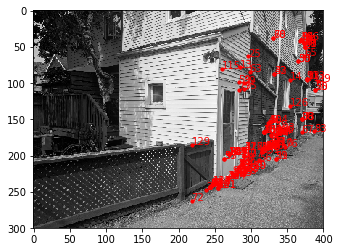

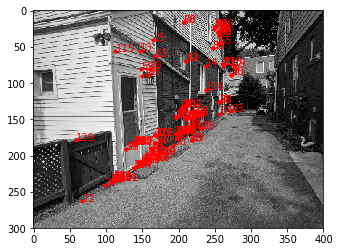

RANSAC number of inlers: 135
16.31053876876831


In [30]:
#%%prun
start = time.time()
fk1,fk2,xk1,xk2,pairs,H0= match(img1_='img/house/house0.jpg',
                             img2_='img/house/house1.jpg',
                             N=1,s=5,sig=2,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num=20,
                             Red=2,crt=0.5,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=2.5,RANSAC_p=0.15)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


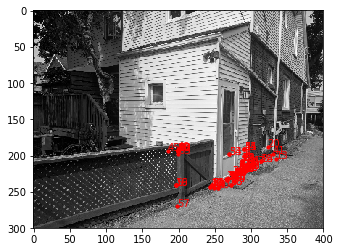

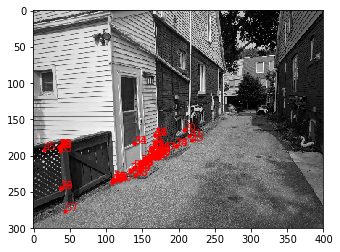

RANSAC number of inlers: 75
18.38875913619995
 

In [31]:
%%prun
start = time.time()
fk1,fk2,xk1,xk2,pairs,H0= match(img1_='img/house/house0.jpg',
                             img2_='img/house/house1.jpg',
                             N=1,s=5,sig=2,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num='max',
                             Red=2,crt=0.5,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=2.5,RANSAC_p=0.15)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


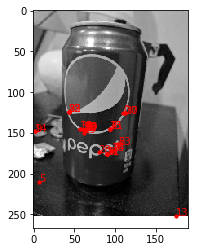

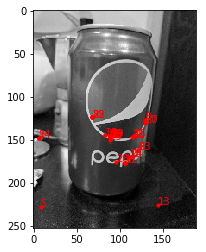

RANSAC number of inlers: 34
6.934528112411499
 

In [32]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,H= match(img1_='img/pepsi1.jpg',
                             img2_='img/pepsi2.jpg',
                             N=2,s=5,sig=1.6,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num='max',
                             Red=4,crt=0.8,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=5)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


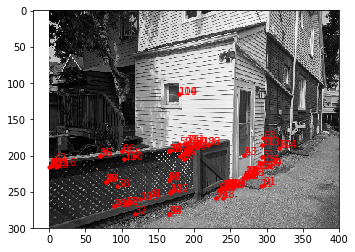

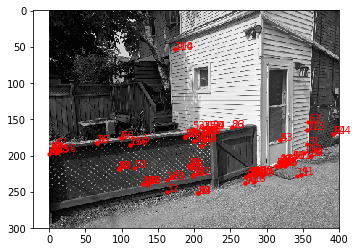

RANSAC number of inlers: 117
35.1207914352417
 

In [33]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,H1= match(img1_='img/house/house0.jpg',
                             img2_='img/house/house8.jpg',
                             N=2,s=5,sig=1.6,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num='max',
                             Red=2,crt=0.8,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=5)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


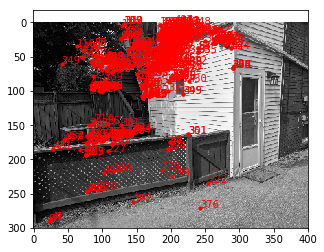

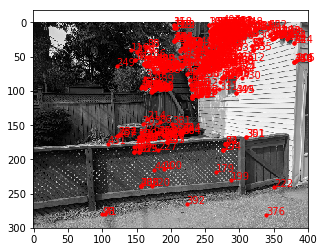

RANSAC number of inlers: 471
30.88100838661194
 

In [34]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,H2= match(img1_='img/house/house8.jpg',
                             img2_='img/house/house23.jpg',
                             N=3,s=5,sig=1.6,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num='max',
                             Red=2,crt=0.5,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=5)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


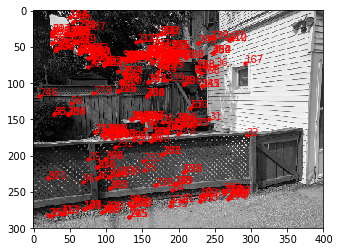

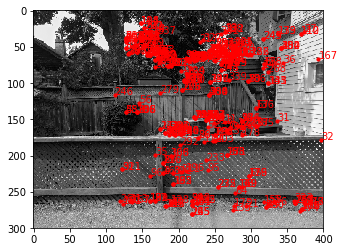

RANSAC number of inlers: 350
21.595725297927856
 

In [35]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,H3= match(img1_='img/house/house23.jpg',
                             img2_='img/house/house22.jpg',
                             N=1,s=5,sig=2,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num=20,
                             Red=2,crt=0.5,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=2.5,RANSAC_p=0.15)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


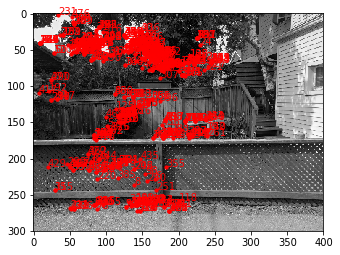

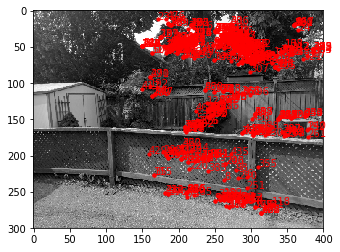

RANSAC number of inlers: 477
27.301596879959106
 

In [36]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,H4= match(img1_='img/house/house22.jpg',
                             img2_='img/house/house18.jpg',
                             N=1,s=5,sig=2,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num=20,
                             Red=2,crt=0.5,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=2.5,RANSAC_p=0.15)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


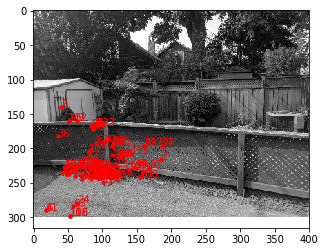

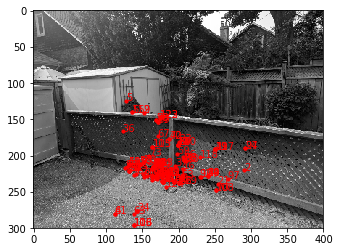

RANSAC number of inlers: 125
33.41494536399841
 

In [37]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,H5= match(img1_='img/house/house18.jpg',
                             img2_='img/house/house16.jpg',
                             N=3,s=5,sig=1.6,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num='max',
                             Red=2,crt=0.8,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=5)
end = time.time()
print((end-start))

Ransac affine/homography best matches:


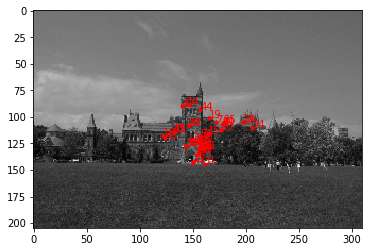

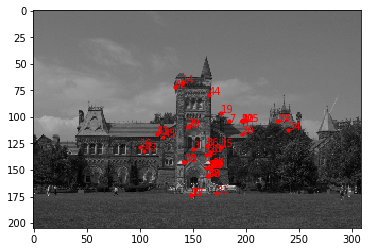

RANSAC number of inlers: 49
10.822304964065552
 

In [40]:
%%prun
start = time.time()

fk1,fk2,xk1,xk2,pairs,_= match(img1_='img/uoft4.jpg',
                             img2_='img/uoft6.jpg',
                             N=3,s=5,sig=1.6,
                             peak_th=0.03,edge_th=10,
                             ilum_sat=0.2,num='max',
                             Red=4,crt=0.8,
                             type_='homography',
                             min_pts=4,
                             nn_plot=False,debug=False,RANSAC_th=5)
end = time.time()
print((end-start))

## General summary:
Planar/Distinctive objects: 
Scale Invariant interest points, SIFT descriptor, matching with nn + affine/homography

Panorama Stiching:
Scale Invariant interest points, SIFT descriptor, matching with nn + homography